# Машинное обучение, РЭШ

## Практическое задание 5. Градиентный бустинг ~~своими руками~~

### Общая информация
Дата выдачи: 06.12.2020

Мягкий дедлайн: 23:59MSK 13.12.2020

Жесткий дедлайн: 23:59MSK 15.12.2020

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). 

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются на my.nes. 


__Задание 1. (0.5 балла)__

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [87]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c hse19-gbm

Единственная переменная (кроме таргета) которую точно нужно удалить - ID объекта в выборке. 

In [54]:
df = pd.read_csv('application_train.csv.zip')
columns_to_delete = ['SK_ID_CURR','TARGET']
X = df.drop(columns_to_delete, axis=1)
y = df.TARGET

Посмотрим на типы столбоцов и пропуски:

In [266]:
X.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215257 entries, 0 to 215256
Data columns (total 120 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   NAME_CONTRACT_TYPE            215257 non-null  object 
 1   CODE_GENDER                   215257 non-null  object 
 2   FLAG_OWN_CAR                  215257 non-null  object 
 3   FLAG_OWN_REALTY               215257 non-null  object 
 4   CNT_CHILDREN                  215257 non-null  int64  
 5   AMT_INCOME_TOTAL              215257 non-null  float64
 6   AMT_CREDIT                    215257 non-null  float64
 7   AMT_ANNUITY                   215249 non-null  float64
 8   AMT_GOODS_PRICE               215058 non-null  float64
 9   NAME_TYPE_SUITE               214344 non-null  object 
 10  NAME_INCOME_TYPE              215257 non-null  object 
 11  NAME_EDUCATION_TYPE           215257 non-null  object 
 12  NAME_FAMILY_STATUS            215257 non-nu

Заполним пропуски:
* Для численных переменных заменим пропущенные значения средними
* Для категориальных переменных - отдельная категория 'missing'


In [55]:
X_modified = X.loc[:, X.dtypes == 'float64'].fillna(X.loc[:, X.dtypes == 'float64'].mean())
X_modified = X_modified.join(X.loc[:, X.dtypes == 'int64'].fillna(X.loc[:, X.dtypes == 'int64'].mean()))
X_modified = X_modified.join(X.loc[:,X.dtypes == 'object'].fillna('missing'))

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_modified, y, train_size = 0.7, random_state = 0)

__Задание 2. (1.5 балла)__

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [196]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
real_vars = X_train.columns[X_train.dtypes.isin(['int64','float64'])]

In [153]:
%%time
lgbm = LGBMClassifier()
lgbm.fit(X_train[real_vars], y_train)
y_pred_lgbm = lgbm.predict_proba(X_test[real_vars])[:, 1]
print('AUC-PR: ', average_precision_score(y_test, y_pred_l))
print('AUC-ROC: ', roc_auc_score(y_test, y_pred_l))

AUC-PR:  0.2178911003494085
AUC-ROC:  0.7375688454093854
CPU times: user 12.8 s, sys: 36 ms, total: 12.9 s
Wall time: 6.81 s


In [267]:
%%time
catmodel = CatBoostClassifier(silent = True)
catmodel.fit(X_train[real_vars], y_train)
y_pred_cat = catmodel.predict_proba(X_test[real_vars])[:, 1]
print('AUC-PR: ', average_precision_score(y_test, y_pred_cat))
print('AUC-ROC: ', roc_auc_score(y_test, y_pred_cat))

AUC-PR:  0.22667651772912395
AUC-ROC:  0.7416462110975538
CPU times: user 2min 44s, sys: 7.32 s, total: 2min 51s
Wall time: 1min 28s


А у меня не получилось значительной разницы в результатах (если не считать таковой различие 1%)

__Задание 3. (3 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения.

Масштаб значений предлагается посмотреть в семинаре про библиотеки.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма. 

In [158]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer
average_precision_scorer=make_scorer(average_precision_score)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [201]:
%%time
params = [{"learning_rate": [0.1, 0.05, 0.01],
           "max_depth": [4, 5, 6],
           "n_estimators": [20, 50, 100, 200]}]
lgbm = LGBMClassifier()
grid_search_lgbm = GridSearchCV(lgbm, param_grid = params, scoring=average_precision_scorer, cv = 3, n_jobs = -1)
grid_search_lgbm.fit(X_train[real_vars], y_train)

CPU times: user 19.2 s, sys: 540 ms, total: 19.8 s
Wall time: 7min 21s


In [202]:
%%time
print(grid_search_lgbm.best_params_)
lgbm = LGBMClassifier(learning_rate=grid_search_lgbm.best_params_['learning_rate'], 
                      max_depth=grid_search_lgbm.best_params_['max_depth'], 
                      n_estimators=grid_search_lgbm.best_params_['n_estimators'])
lgbm.fit(X_train[real_vars], y_train)
y_pred_lgbm = lgbm.predict_proba(X_test[real_vars])[:, 1]
print('AUC-PR: ', average_precision_score(y_test, y_pred_lgbm))
print('AUC-ROC: ', roc_auc_score(y_test, y_pred_lgbm))

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
AUC-PR:  0.2293560149822249
AUC-ROC:  0.7437662959078706
CPU times: user 19.3 s, sys: 59.6 ms, total: 19.4 s
Wall time: 10.1 s


Можно заметить, что модель переобучилась на train. Например, с learning_rate = 0.05 на тесте лучше резы. 

In [191]:
%%time
params = [{"learning_rate": [0.1, 0.05],
           "max_depth": [5, 6, 7],
           "n_estimators": [20, 50, 100, 200]}]
catmodel = CatBoostClassifier(silent = True)
grid_search_cat = GridSearchCV(catmodel, param_grid = params, scoring=average_precision_scorer, cv = 3, n_jobs = -1)
grid_search_cat.fit(X_train[real_vars], y_train)
grid_search_cat.best_params_

CPU times: user 31.3 s, sys: 1.58 s, total: 32.9 s
Wall time: 8min 17s


In [194]:
%%time
print(grid_search_cat.best_params_)
catmodel = CatBoostClassifier(silent = True,
                              learning_rate=grid_search_cat.best_params_['learning_rate'], 
                              max_depth=grid_search_cat.best_params_['max_depth'], 
                              n_estimators=grid_search_cat.best_params_['n_estimators'])
catmodel.fit(X_train[real_vars], y_train)
y_pred_cat = catmodel.predict_proba(X_test[real_vars])[:, 1]
print('AUC-PR: ', average_precision_score(y_test, y_pred_cat))
print('AUC-ROC: ', roc_auc_score(y_test, y_pred_cat))

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
AUC-PR:  0.23078166513054413
AUC-ROC:  0.7444565921591926
CPU times: user 30.8 s, sys: 1.37 s, total: 32.2 s
Wall time: 16.7 s


В данном случае (на грубой сетке) оптимальные параметры совпадают. Сетка грубая из-за значительного времени обучения. Однако в общем случае для LightGBM требуются более глубокие деревья из-за least-wise tree growth. При этом, ему же нужно будет чуть меньше деревьев, чем CatBoost из-за более гибкого дообучения на остатки (тот же least-wise growth).

__Задание 4. (2 балла)__

Добавьте категориальные признаки к вещественным. Обработку категориальных признаков проводите с помощью One-Hot-Encoding. Как поменялось качество моделей? 


In [222]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
categ_vars = X_train.columns[X_train.dtypes == 'object']

In [227]:
%%time
lgbm = LGBMClassifier(learning_rate=grid_search_lgbm.best_params_['learning_rate'], 
                      max_depth=grid_search_lgbm.best_params_['max_depth'], 
                      n_estimators=grid_search_lgbm.best_params_['n_estimators'])

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown="ignore"), categ_vars)], remainder='passthrough')
pipeline_lgbm = Pipeline(steps=[
    ('ohe', column_transformer),
    ('lgbm', lgbm)
])

pipeline_lgbm.fit(X_train, y_train)
y_pred_lgbm = pipeline_lgbm.predict_proba(X_test)[:, 1]
print('AUC-PR: ', average_precision_score(y_test, y_pred_lgbm))
print('AUC-ROC: ', roc_auc_score(y_test, y_pred_lgbm))

AUC-PR:  0.24553222054154356
AUC-ROC:  0.7564695035142617
CPU times: user 30.1 s, sys: 247 ms, total: 30.3 s
Wall time: 16.5 s


In [228]:
%%time
catmodel = CatBoostClassifier(silent = True,
                              learning_rate=grid_search_cat.best_params_['learning_rate'], 
                              max_depth=grid_search_cat.best_params_['max_depth'], 
                              n_estimators=grid_search_cat.best_params_['n_estimators'])

pipeline_cat = Pipeline(steps=[
    ('ohe', column_transformer),
    ('cat', catmodel)
])

pipeline_cat.fit(X_train, y_train)
y_pred_cat = pipeline_cat.predict_proba(X_test)[:, 1]
print('AUC-PR: ', average_precision_score(y_test, y_pred_cat))
print('AUC-ROC: ', roc_auc_score(y_test, y_pred_cat))

AUC-PR:  0.246788099326599
AUC-ROC:  0.7580351773164098
CPU times: user 44.6 s, sys: 1.74 s, total: 46.3 s
Wall time: 28.1 s


Качество ощутимо выросло для обеих моделей. Время обучения - тоже. 

__Задание 5. (1.5 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество. Обратите внимание на данные, на которых обучаются 

In [232]:
%%time
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [('lgbm', pipeline_lgbm),
              ('cat', pipeline_cat)]
meta = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=3)
meta.fit(X_train, y_train)
y_pred_meta = meta.predict_proba(X_test)[:, 1]
print('AUC-PR: ', average_precision_score(y_test, y_pred_meta))
print('AUC-ROC: ', roc_auc_score(y_test, y_pred_meta))

AUC-PR:  0.2495837092721122
AUC-ROC:  0.7596938245446656
CPU times: user 3min 52s, sys: 5.8 s, total: 3min 57s
Wall time: 2min 18s


Для блендинга нам нужно использовать logit для мета-модели (ведь мы все еще решаем задачу бинарной классификации). Так же обязательна кросс-валидация (обсуждали на лекции). Видно, что качество еще выросло. 

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог, с которого начинается "хвост" менее важных признаков) и обучите модель с теми же параметрами на получившихся данных. Сильно ли упало качество при удалении признаков?

In [253]:
import seaborn as sns

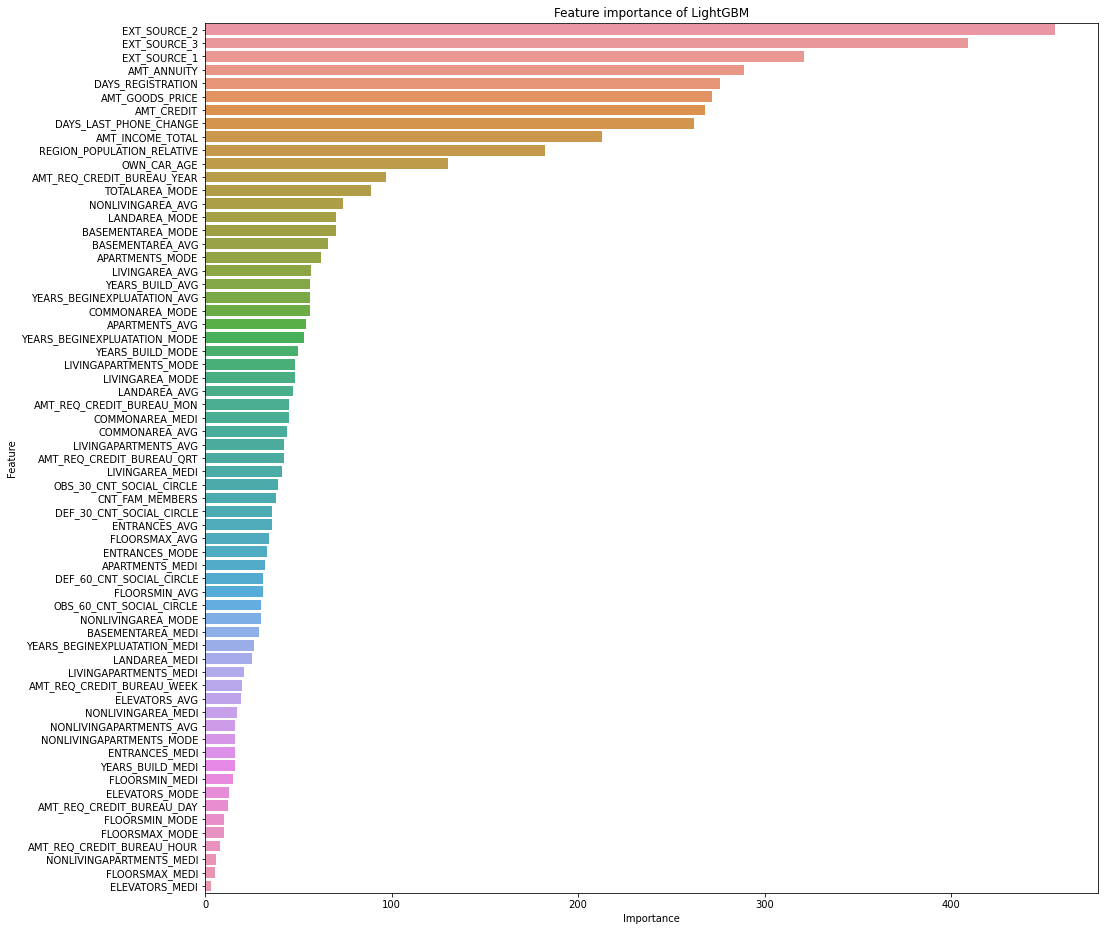

In [268]:
lgbm = LGBMClassifier(learning_rate=grid_search_lgbm.best_params_['learning_rate'], 
                      max_depth=grid_search_lgbm.best_params_['max_depth'], 
                      n_estimators=grid_search_lgbm.best_params_['n_estimators'])
lgbm.fit(X_train[real_vars], y_train)

lgbm_importance = pd.concat([pd.Series(X_train[real_vars].columns), pd.Series(lgbm.feature_importances_)],axis=1)
lgbm_importance.columns = ['Feature','Importance']
lgbm_importance.sort_values(by = 'Importance', ascending=False, inplace=True)


plt.figure(figsize=(16, 16))
sns.barplot(x=lgbm_importance.Importance, y=lgbm_importance.Feature)
plt.title('Feature importance of LightGBM')
plt.show()

Давайте возьмем все с Importance > 50

In [260]:
%%time
feature_subset = lgbm_importance[lgbm_importance.Importance > 50].Feature
lgbm_restricted = LGBMClassifier(learning_rate=grid_search_lgbm.best_params_['learning_rate'], 
                      max_depth=grid_search_lgbm.best_params_['max_depth'], 
                      n_estimators=grid_search_lgbm.best_params_['n_estimators'])
lgbm_restricted.fit(X_train[feature_subset], y_train)
y_pred_lgbm = lgbm_restricted.predict_proba(X_test[feature_subset])[:, 1]
print('AUC-PR: ', average_precision_score(y_test, y_pred_lgbm))
print('AUC-ROC: ', roc_auc_score(y_test, y_pred_lgbm))

AUC-PR:  0.2276786545738606
AUC-ROC:  0.7412615627390231
CPU times: user 9.7 s, sys: 43.4 ms, total: 9.75 s
Wall time: 5.03 s


В третьем пункте качество LightGBM было 22.936%, стало 22.768%. Видно, что после выкидывания оно упало (очевидно). Можно даже сказать, что значительно: разница уже в первом знаке после запятой. Важна еще разница во времени построения, конечно, но я бы не стал выкидывать эти признаки. 

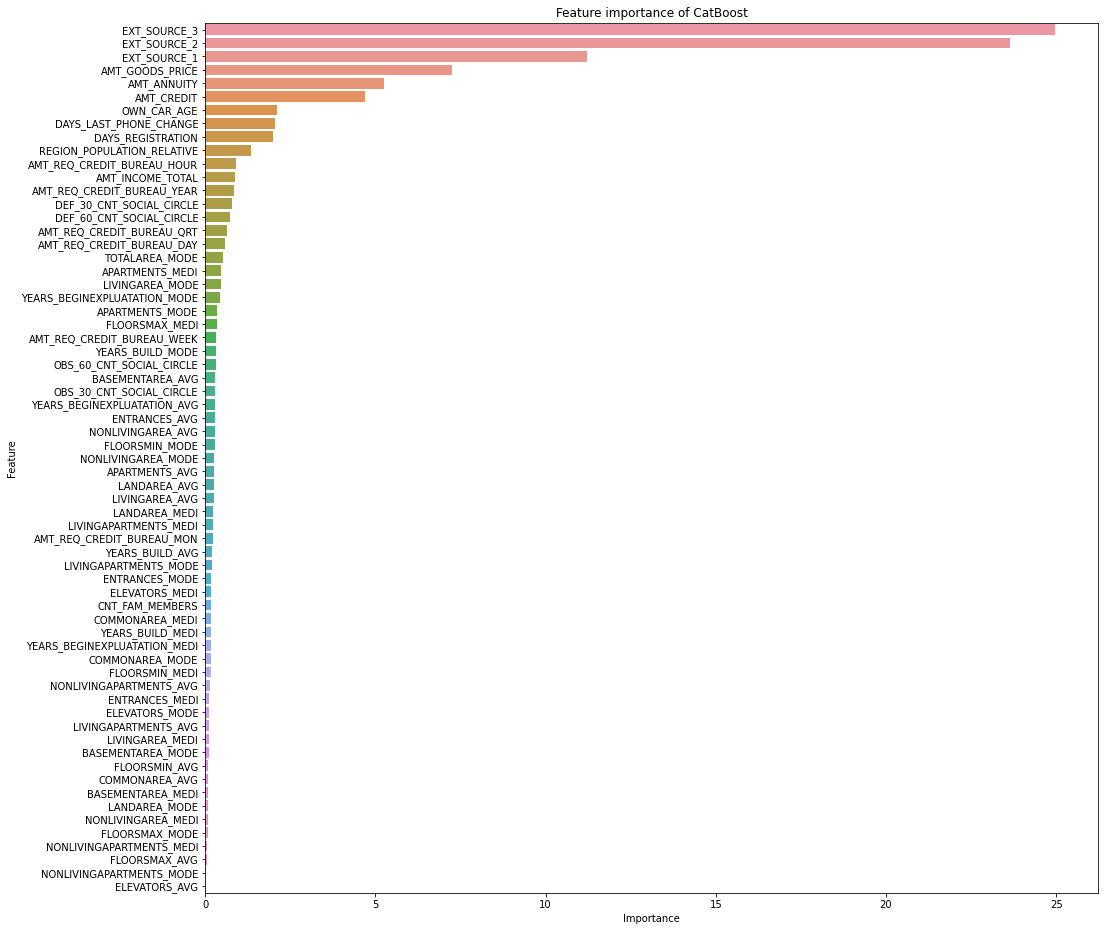

In [269]:
catmodel = CatBoostClassifier(silent = True,
                              learning_rate=grid_search_cat.best_params_['learning_rate'], 
                              max_depth=grid_search_cat.best_params_['max_depth'], 
                              n_estimators=grid_search_cat.best_params_['n_estimators'])
catmodel.fit(X_train[real_vars], y_train)

cat_importance = pd.concat([pd.Series(X_train[real_vars].columns), pd.Series(catmodel.feature_importances_)],axis=1)
cat_importance.columns = ['Feature','Importance']
cat_importance.sort_values(by = 'Importance', ascending=False, inplace=True)


plt.figure(figsize=(16, 16))
sns.barplot(x=cat_importance.Importance, y=cat_importance.Feature)
plt.title('Feature importance of CatBoost')
plt.show()

In [265]:
%%time
feature_subset = cat_importance[cat_importance.Importance > 1].Feature
catmodel_restricted = CatBoostClassifier(silent = True,
                              learning_rate=grid_search_cat.best_params_['learning_rate'], 
                              max_depth=grid_search_cat.best_params_['max_depth'], 
                              n_estimators=grid_search_cat.best_params_['n_estimators'])
catmodel_restricted.fit(X_train[feature_subset], y_train)
y_pred_cat = catmodel_restricted.predict_proba(X_test[feature_subset])[:, 1]
print('AUC-PR: ', average_precision_score(y_test, y_pred_cat))
print('AUC-ROC: ', roc_auc_score(y_test, y_pred_cat))

AUC-PR:  0.22874299701397402
AUC-ROC:  0.7421518441276618
CPU times: user 20.3 s, sys: 1.31 s, total: 21.6 s
Wall time: 11.2 s


Качество было 23.078%, стало 22.874%. Снова относительно значительное падение. Выводы те же. 